# **Task 3: Forecast Future Market Trends**

In [1]:
# !pip uninstall -y numpy pandas pmdarima
# !pip install numpy==1.26.4 pandas==2.2.2 pmdarima

In [15]:
import warnings, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

import joblib
import yfinance as yf

# pmdarima for ARIMA models
import pmdarima as pm

# keras for LSTM
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [19]:
# Utility functions
# ---------------------------
def load_series(ticker='TSLA', start='2015-0y-01', end='2025-07-31'):
    """Download close price series (or load from local if you have it)."""
    try:
        df = yf.download(ticker, start=start, end=end, progress=False)
        if df.empty:
            raise ValueError("No data returned from yfinance.")
        series = df['Close'].dropna()
        return series
    except Exception as e:
        raise RuntimeError(f"Failed to load series: {e}")

def load_arima_model(path):
    try:
        model = joblib.load(path)
        return model
    except Exception as e:
        raise RuntimeError(f"Failed to load ARIMA model from {path}: {e}")

def load_lstm_model(path):
    try:
        model = load_model(path)
        return model
    except Exception as e:
        raise RuntimeError(f"Failed to load LSTM model from {path}: {e}")

def business_day_index(last_date, horizon):
    """Return a DatetimeIndex of next `horizon` business days after last_date (exclusive)."""
    start = pd.to_datetime(last_date) + pd.Timedelta(days=1)
    return pd.bdate_range(start=start, periods=horizon)

# ---------------------------
# Forecasting functions
# ---------------------------
def forecast_arima(model, last_date_index, horizon):
    """Forecast using pmdarima ARIMA-like model with conf intervals."""
    try:
        preds, conf_int = model.predict(n_periods=horizon, return_conf_int=True, alpha=0.05)
        return np.array(preds), np.array(conf_int)
    except Exception as e:
        raise RuntimeError(f"ARIMA forecast failed: {e}")

def forecast_sarima(model, last_date_index, horizon):
    """SARIMA uses same API as ARIMA in pmdarima (we treat similarly)."""
    return forecast_arima(model, last_date_index, horizon)

def forecast_lstm(lstm_model, full_series, look_back=20, horizon=126):
    """
    Multi-step iterative LSTM forecast:
    - Fit MinMaxScaler on full_series (practical when you don't have saved scaler)
    - Use last `look_back` scaled values to generate iterative forecasts
    - Return preds and approximate conf intervals using training residual std
    """
    try:
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled = scaler.fit_transform(full_series.values.reshape(-1,1)).flatten()

        # prepare input: last look_back scaled values
        input_seq = scaled[-look_back:].copy().reshape(1, look_back, 1)

        preds_scaled = []
        for _ in range(horizon):
            p = lstm_model.predict(input_seq, verbose=0)[0,0]
            preds_scaled.append(p)
            # slide window
            input_seq = np.concatenate([input_seq[:,1:,:], np.array(p).reshape(1,1,1)], axis=1)

        preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()

        # Approximate CI: use residual std from one-step on-sample predictions
        # compute simple in-sample residuals by predicting on train windows
        X_all, y_all = [], []
        for i in range(look_back, len(scaled)):
            X_all.append(scaled[i-look_back:i])
            y_all.append(scaled[i])
        X_all = np.array(X_all).reshape(-1, look_back, 1)
        y_all = np.array(y_all)
        # Predict in-sample (fast, but may be large)
        preds_in_sample = lstm_model.predict(X_all, verbose=0).flatten()
        preds_in_sample_inv = scaler.inverse_transform(preds_in_sample.reshape(-1,1)).flatten()
        y_all_inv = scaler.inverse_transform(y_all.reshape(-1,1)).flatten()
        resid = y_all_inv - preds_in_sample_inv
        resid_std = np.nanstd(resid)

        # For h-step ahead CI, approximate width ~ z * resid_std * sqrt(h)
        z = 1.96
        ci_lower = preds - z * resid_std * np.sqrt(np.arange(1, horizon+1))
        ci_upper = preds + z * resid_std * np.sqrt(np.arange(1, horizon+1))

        return preds, np.vstack([ci_lower, ci_upper]).T, resid_std
    except Exception as e:
        raise RuntimeError(f"LSTM forecast failed: {e}")

# ---------------------------
# Plotting
# ---------------------------
def plot_forecasts(history, arima_fc=None, arima_ci=None,
                   sarima_fc=None, sarima_ci=None,
                   lstm_fc=None, lstm_ci=None,
                   horizon_index=None, title="Forecast vs History"):
    plt.figure(figsize=(14,7))
    plt.plot(history.index, history.values, label='Actual Price', color='green')

    if (arima_fc is not None) and (horizon_index is not None):
        plt.plot(horizon_index, arima_fc, label='ARIMA Forecast', color='yellow', linestyle='--')
        plt.fill_between(horizon_index, arima_ci[:,0], arima_ci[:,1], color='C0', alpha=0.15)

    if (sarima_fc is not None) and (horizon_index is not None):
        plt.plot(horizon_index, sarima_fc, label='SARIMA Forecast', color='orange',linestyle='--')
        plt.fill_between(horizon_index, sarima_ci[:,0], sarima_ci[:,1], color='C1', alpha=0.15)

    if (lstm_fc is not None) and (horizon_index is not None):
        plt.plot(horizon_index, lstm_fc, label='LSTM Forecast', color='blue', linestyle='--')
        plt.fill_between(horizon_index, lstm_ci[:,0], lstm_ci[:,1], color='C2', alpha=0.12)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------
# Interpretation helper
# ---------------------------
def interpret_forecast(forecast_series, ci_array):
    """
    Simple automatic interpretation:
    - trend slope (linear regression)
    - CI width at start vs end and relative growth
    - basic volatility summary (std of forecast returns)
    """
    try:
        idx = np.arange(len(forecast_series)).reshape(-1,1)
        lr = LinearRegression().fit(idx, forecast_series)
        slope = lr.coef_[0]

        # CI widths
        ci_widths = ci_array[:,1] - ci_array[:,0]
        start_width = float(ci_widths[0])
        end_width = float(ci_widths[-1])
        growth = (end_width - start_width) / start_width if start_width != 0 else np.nan

        # volatility (returns) on forecast
        returns = pd.Series(forecast_series).pct_change().dropna()
        vol = float(returns.std() * np.sqrt(252))  # annualized vol approx

        interpretation = {
            'slope_per_step': float(slope),
            'start_CI_width': start_width,
            'end_CI_width': end_width,
            'CI_width_growth_pct': growth * 100 if not np.isnan(growth) else None,
            'forecast_annualized_volatility': vol
        }
        return interpretation
    except Exception as e:
        raise RuntimeError(f"Interpretation failed: {e}")

# ---------------------------
# Main runner for Task 3
# ---------------------------
def run_task3(arima_path='ARIMA_model.pkl', sarima_path='SARIMA_model.pkl',
              lstm_path='LSTM_model.h5', ticker='TSLA',
              start='2015-07-01', end='2025-07-31', horizon_days=126, look_back=20):
    """
    horizon_days: number of business days to forecast (e.g., 126 ≈ 6 months, 252 ≈ 12 months)
    """
    try:
        # Load historical series
        hist = load_series(ticker=ticker, start=start, end=end)
        last_date = hist.index[-1]

        # Build future index of business days
        horizon_idx = business_day_index(last_date, horizon_days)

        # Load models
        arima_model_obj = load_arima_model(arima_path) if os.path.exists(arima_path) else None
        sarima_model_obj = load_arima_model(sarima_path) if os.path.exists(sarima_path) else None
        lstm_model_obj = load_lstm_model(lstm_path) if os.path.exists(lstm_path) else None

        display(f"Loaded models -> ARIMA: {bool(arima_model_obj)}, SARIMA: {bool(sarima_model_obj)}, LSTM: {bool(lstm_model_obj)}")

        # Forecasts placeholders
        arima_fc = arima_ci = sarima_fc = sarima_ci = None
        if arima_model_obj is not None:
            arima_fc, arima_ci = forecast_arima(arima_model_obj, last_date, horizon_days)
            arima_ci = np.array(arima_ci)  # shape (horizon, 2)
        if sarima_model_obj is not None:
            sarima_fc, sarima_ci = forecast_sarima(sarima_model_obj, last_date, horizon_days)
            sarima_ci = np.array(sarima_ci)

        lstm_fc = lstm_ci = lstm_resid_std = None
        if lstm_model_obj is not None:
            lstm_fc, lstm_ci, lstm_resid_std = forecast_lstm(lstm_model_obj, hist, look_back=look_back, horizon=horizon_days)

        # Plot everything
        plot_forecasts(hist, arima_fc=arima_fc, arima_ci=arima_ci,
                       sarima_fc=sarima_fc, sarima_ci=sarima_ci,
                       lstm_fc=lstm_fc, lstm_ci=lstm_ci,
                       horizon_index=horizon_idx,
                       title=f"{ticker} Historical and {horizon_days}-Day Forecasts")

        # Interpret and display results
        results = {}
        if arima_fc is not None:
            results['ARIMA'] = interpret_forecast(arima_fc, arima_ci)
            display("ARIMA interpretation:")
            display(results['ARIMA'])
        if sarima_fc is not None:
            results['SARIMA'] = interpret_forecast(sarima_fc, sarima_ci)
            display("SARIMA interpretation:")
            display(results['SARIMA'])
        if lstm_fc is not None:
            results['LSTM'] = interpret_forecast(lstm_fc, lstm_ci)
            results['LSTM']['residual_std'] = float(lstm_resid_std)
            display("LSTM interpretation:")
            display(results['LSTM'])

        # Basic textual summary
        summary_lines = []
        if lstm_fc is not None:
            # pick LSTM as main for text summary if available
            interp = results['LSTM']
            trend = "upward" if interp['slope_per_step'] > 0 else ("downward" if interp['slope_per_step'] < 0 else "flat")
            summary_lines.append(f"LSTM forecast trend: {trend} (slope per step {interp['slope_per_step']:.6f})")
            summary_lines.append(f"Forecast annualized volatility (approx): {interp['forecast_annualized_volatility']:.2%}")
            summary_lines.append(f"CI width growth over horizon: {interp['CI_width_growth_pct']:.2f}%")
        else:
            # fallback to ARIMA
            key = 'ARIMA' if arima_fc is not None else ('SARIMA' if sarima_fc is not None else None)
            if key:
                interp = results[key]
                trend = "upward" if interp['slope_per_step'] > 0 else ("downward" if interp['slope_per_step'] < 0 else "flat")
                summary_lines.append(f"{key} forecast trend: {trend} (slope per step {interp['slope_per_step']:.6f})")
                summary_lines.append(f"CI width growth over horizon: {interp['CI_width_growth_pct']:.2f}%")

        display("Quick summary:")
        for ln in summary_lines:
            display(ln)

        return {'history': hist, 'horizon_index': horizon_idx, 'forecasts': {'ARIMA': (arima_fc, arima_ci),
                                                                             'SARIMA': (sarima_fc, sarima_ci),
                                                                             'LSTM': (lstm_fc, lstm_ci)},
                'interpretation': results}

    except Exception as e:
        display(f"Error running Task 3: {e}")
        raise

'Loaded models -> ARIMA: True, SARIMA: True, LSTM: True'

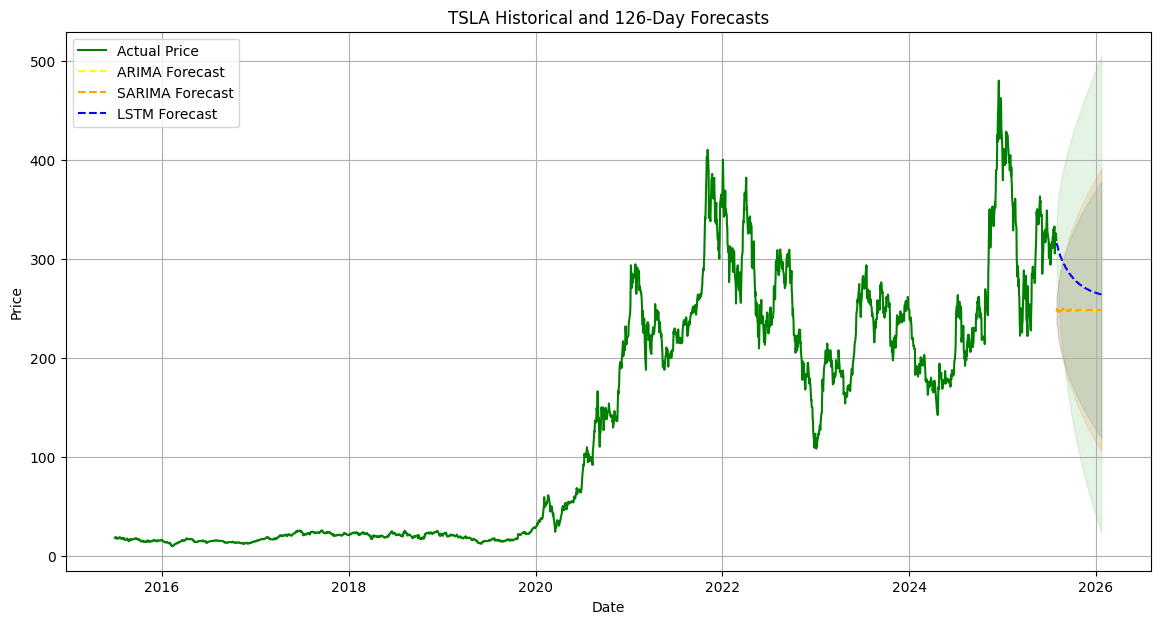

'ARIMA interpretation:'

{'slope_per_step': 0.0,
 'start_CI_width': 23.02535032150081,
 'end_CI_width': 258.4589163405474,
 'CI_width_growth_pct': 1022.4972160323719,
 'forecast_annualized_volatility': 0.0}

'SARIMA interpretation:'

{'slope_per_step': 0.0020556514372793316,
 'start_CI_width': 22.402491032179825,
 'end_CI_width': 285.26828152721737,
 'CI_width_growth_pct': 1173.3775057311561,
 'forecast_annualized_volatility': 0.02724387403732397}

'LSTM interpretation:'

{'slope_per_step': -0.35681195359002976,
 'start_CI_width': 42.87088935297663,
 'end_CI_width': 481.2245394753995,
 'CI_width_growth_pct': 1022.4972160321814,
 'forecast_annualized_volatility': 0.017118401284624895,
 'residual_std': 10.936451365555254}

'Quick summary:'

'LSTM forecast trend: downward (slope per step -0.356812)'

'Forecast annualized volatility (approx): 1.71%'

'CI width growth over horizon: 1022.50%'

In [20]:
# Run the main function
results = run_task3(arima_path='ARIMA_model.pkl', sarima_path='SARIMA_model.pkl', lstm_path='LSTM_model.h5',
                   ticker='TSLA', start='2015-07-01', end='2025-07-31', horizon_days=126, look_back=20)